# Stellar Mass Profiles

This script seeks to reproduce the stellar mass profiles from Pillepich 2018 using the IllustrisTNG-100 and IllustrisTNG-300 simulations.

* Central galaxies - do not reside within $R_{200c}$ or $R_{500c}$ of a larger halo
* Satellite galaxies - reside within a certain 3D spherical aperture
* Intra-cluster light (ICL) - the stellar mass particles beyond this fixed aperture but within the maximum boundary of the virial radius
* Diffuse mass - all stellar mass in a group and cluster within the virial radius (central+ICL)
* The total stellar mass of a group or cluster is the sum of all components (central+ICL+satellites)

Useful Information:
* A stellar particle can be associated to only one galaxy (central or satellite)
* Might need to adopt initial mass function (IMF) from Chabrier (2003)
    * The IMF specifies the fractional distribution in mass of a newly formed stellar system. 

Information needed from IllustrisTNG100 and TNG300 for stellar mass profiles

For the central galaxy, we need:

* Paper focuses on groups/clusters with masses of $10^{13} <= M_{200c}/M_{sol} <= 10^{15}$ 
    * This appears to be Group_M_Mean_200 in IllustrisTNG
        * Total Mass of this group enclosed in a sphere whose mean density is 200 times the mean density of the Universe, at the time the halo is considered.
    * The mass of the central galaxy is always defined within a fixed 3D aperture
    * Stellar mass can be obtained using "SubhaloMassType" -> "Masses" in PartType4. Adding up all of the masses in the cell within a given radius (aperture) will allow us to obtain the mass of the central galaxy
* The central galaxy stellar mass is defined as the sum of all stellar particles mass within fixed apertures (3D, 10, 30, 100 physics or comoving kpc)
* Intra-cluster light (ICL) - the stellar mass particles beyond this fixed aperture but within the maximum boundary of the virial radius
* Stellar half mass radius - measured as the 3D radius containing half of the stellar mass of all constituent stars
    * This is "SubhaloMassInHalfRadType" in IllustrisTNG
* Redshifts z<1
    * Snapshot 50-99 cover redshifts between 0 and 1
* Virial radius (R_200c)

In [1]:
import illustris_python as il
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sandyspicer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import requests

baseUrl = 'http://www.illustris-project.org/api/'
headers = {"api-key":"4e2c93455bbc8e991a91a61ef5e11daa"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

# Steps - Copy in terminal window
* mkdir IllustrisTNG100-3
* mkdir IllustrisTNG100-3/groups_99
* cd IllustrisTNG100-3/groups_99/
* wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: 4e2c93455bbc8e991a91a61ef5e11daa" "http://www.illustris-project.org/api/TNG100-3/files/groupcat-99/?format=api"

If you haven't already, let's download the example scripts from Bitbucket and make sure they are on your IDL_PATH, MATLABPATH, or PYTHONPATH, respectively. For example:

* cd ~
* hg clone http://www.bitbucket.org/illustris/illustris_python
* export PYTHONPATH=~/illustris_python # add to .bashrc

If this does not work, go to the link and download manually

For all TNG simulations the "offset" files are separate and must be downloaded in addition to the group catalog files, in order to load (i) single halos or subhalos, or (ii) load the particles of particular halos or subhalos. For example, if you were working with TNG100-3 at z=0, then:
* mkdir -p ~/TNG100-3/postprocessing/offsets/
* cd ~/TNG100-3/postprocessing/offsets/
* wget --content-disposition --header="API-Key: INSERT_API_KEY_HERE" "http://www.tng-project.org/api/TNG100-3/files/offsets.99.hdf5"

In all cases, these scripts assume that you have downloaded local copies of the relevant files. Paths to files are defined with respect to a basePath which is passed in to all read functions. The locations of group catalog files, snapshot files, and merger trees files are then specified in a handful of functions, e.g. gcPath(), snapPath(), and treePath(). These can be modified as necessary to point to your local files, but it is best to keep a directory structure organized as e.g.:

* TNG100-1/
* TNG100-1/output/
    * group catalogs: TNG100-1/output/groups_099/fof_subhalo_tab_099.*.hdf5
    * snapshots: TNG100-1/output/snapdir_099/snap_099.*.hdf5
* TNG100-1/postprocessing/
    * offsets: TNG100-1/postprocessing/offsets/offsets_*.hdf5
    * SubLink mergertree: TNG100-1/postprocessing/trees/SubLink/tree_extended.*.hdf5
    * other catalogs: TNG100-1/postprocessing/catalog_name/files*.hdf5
* where you would set basePath = 'TNG100-1/output/' in the following.

In [3]:
# Replace with your basePath
basePath = '/Users/sandyspicer/Desktop/Research_with_Moustakas/stellar_mass_profiles/IllustrisTNG100-3/output'
fields = ['SubhaloMass','SubhaloMassType','SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)

Text(0,0.5,'Star Formation Rate [$M_\\odot / yr$]')

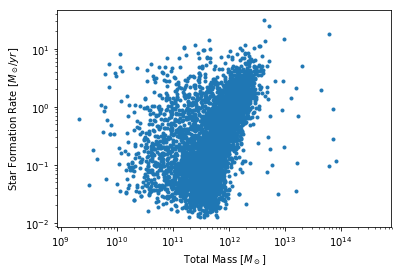

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
plt.plot(mass_msun,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')

* GroupFirstSub - Index into the Subhalo table of the first/primary/most massive Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! In this case, a value of -1 indicates that this FoF group has no subhalos.
* Group_R_Crit200 - Comoving Radius of a sphere centered at the GroupPos of this Group whose mean density is 200 times the critical density of the Universe, at the time the halo is considered. In other words, the virial radius.
* GroupCM - Center of mass of the group, computed as the sum of the mass weighted relative coordinates of all particles/cells in the group, of all types. Comoving coordinate. 
* GroupPos - Spatial position within the periodic box (of the particle with the minimum gravitational potential energy). Comoving coordinate.
* GroupMassType - Sum of the individual masses of every particle/cell, split into the six different types, in this group. Note: Wind phase cells are counted as gas (type 0) for GroupMassType.

Every FoF group is associated to one central SUBFIND halo and possibly a halo of satellite objects

In [5]:
import h5py
f = h5py.File('/Users/sandyspicer/Desktop/Research_with_Moustakas/stellar_mass_profiles/IllustrisTNG100-3/output/groups_099/fof_subhalo_tab_099.0.hdf5', 'r')

In [6]:
list(f)

['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']

In [7]:
list(f['Group'])

['GroupBHMass',
 'GroupBHMdot',
 'GroupCM',
 'GroupFirstSub',
 'GroupGasMetalFractions',
 'GroupGasMetallicity',
 'GroupLen',
 'GroupLenType',
 'GroupMass',
 'GroupMassType',
 'GroupNsubs',
 'GroupPos',
 'GroupSFR',
 'GroupStarMetalFractions',
 'GroupStarMetallicity',
 'GroupVel',
 'GroupWindMass',
 'Group_M_Crit200',
 'Group_M_Crit500',
 'Group_M_Mean200',
 'Group_M_TopHat200',
 'Group_R_Crit200',
 'Group_R_Crit500',
 'Group_R_Mean200',
 'Group_R_TopHat200']

In [8]:
# Load parameters for snapshot 99 (redshift 0)
GroupFirstSub = f['Group']['GroupFirstSub']
Group_R_Crit200 = f['Group']['Group_R_Crit200']
Group_M_Crit200 = f['Group']['Group_M_Crit200']
Group_M_Mean200 = f['Group']['Group_M_Mean200']
GroupCM = f['Group']['GroupCM']
GroupPos = f['Group']['GroupPos']
GroupMassType = f['Group']['GroupMassType']

In [9]:
list(Group_M_Crit200)

[25268.787,
 25467.057,
 22858.674,
 11426.892,
 17188.771,
 13325.995,
 14002.103,
 14234.35,
 5891.2344,
 14541.415,
 10908.741,
 8874.756,
 5363.882,
 3248.6284,
 7680.481]

In [10]:
list(Group_M_Mean200)

[35725.668,
 36437.473,
 29775.084,
 19249.312,
 21841.674,
 18596.117,
 18672.6,
 19661.514,
 9894.486,
 20089.486,
 15701.275,
 13029.27,
 12163.764,
 6794.026,
 10070.93]

In [11]:
print(Group_M_Mean200[1])

36437.473


In [12]:
# All of the central galaxies indices in snapshot 99
central_galaxies = list(GroupFirstSub)
print(central_galaxies)

[0, 544, 953, 1285, 1662, 1893, 2164, 2383, 2641, 2879, 3043, 3229, 3403, 3605, 3760]


In [13]:
ptNumGas = il.snapshot.partTypeNum('gas') # 0
ptNumStars = il.snapshot.partTypeNum('stars') # 4

stellarmass = []
gasmass = []
totalmass = []

for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath,99,subhaloID=GroupFirstSub[i])
    gas_mass   = all_fields['SubhaloMassType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassType'][ptNumStars]
    total_mass = all_fields['SubhaloMass']
    stellarmass.append(stars_mass)
    gasmass.append(gas_mass)
    totalmass.append(total_mass)

In [14]:
print(totalmass)

[29804.924, 29481.428, 24644.398, 15315.601, 16710.242]


In [15]:
# Example of working with the cutout files to create stellar profile
f2 = h5py.File('/Users/sandyspicer/Desktop/Research_with_Moustakas/stellar_mass_profiles/IllustrisTNG100-3/output/groups_099/cutout_544.hdf5', 'r')

In [16]:
stellar_hsml = list(f2['PartType4']['StellarHsml'])

In [17]:
stellar_masses = list(f2['PartType4']['Masses'])

In [18]:
birth_pos = list(f2['PartType4']['BirthPos'])

In [19]:
coordinates = list(f2['PartType4']['Coordinates'])

In [20]:
stellar_hsml = np.array(stellar_hsml)
stellar_masses = np.array(stellar_masses)
print(len(stellar_masses))

18314


In [21]:
# Can also access .json file (you need internet connection for this)

subhalo_mass = []
subhalo_position = []
subhalo_sfr = []
subhalo_masstype = []
subhalo_metallicity = []
subhalo_cm = []
subhalo_pos = []

for c in central_galaxies:
    snap_url = "http://www.tng-project.org/api/TNG100-3/snapshots/99/subhalos/"+str(c)+"/info.json"
    #snap_url = "http://www.tng-project.org/api/TNG100-3/snapshots/99/subhalos/"+str(c)+"/cutout.hdf5"
    snap = get(snap_url)
    subhalo_mass.append(snap['SubhaloMass'])
    subhalo_position.append(snap['SubhaloPos'])
    subhalo_sfr.append(snap['SubhaloSFR'])
    subhalo_masstype.append(snap['SubhaloMassType'])
    subhalo_metallicity.append(snap['SubhaloGasMetallicity'])
    subhalo_cm.append(snap['SubhaloCM'])
    subhalo_pos.append(snap['SubhaloPos']) 

In [22]:
central_galaxy = subhalo_pos[0]
radius = []

for c in range(0,len(coordinates)):
    x = coordinates[c][0]-central_galaxy[0]
    y = coordinates[c][1]-central_galaxy[1]
    z = coordinates[c][2]-central_galaxy[2]
    
#     x = birth_pos[c][0]-central_galaxy[0]
#     y = birth_pos[c][1]-central_galaxy[1]
#     z = birth_pos[c][2]-central_galaxy[2]
    
    radius.append(np.sqrt(x**2 + y**2 + z**2))

In [23]:
# Something is wrong here because these positions are far off from each other
# Need to figure out why this is happening
print(central_galaxy[0])
print(coordinates[13][0])

851.4019775390625
19725.840169183204


In [24]:
#print(radius)

Attempt at creating a stellar profile for a single central galaxy

In [25]:
sum_stellar_mass = []
for r in range(0,len(radius)):
    ww = np.where(radius<radius[r])
    new_stellar_mass = stellar_masses
    summed_mass = np.sum(new_stellar_mass[ww])
    sum_stellar_mass.append(summed_mass)

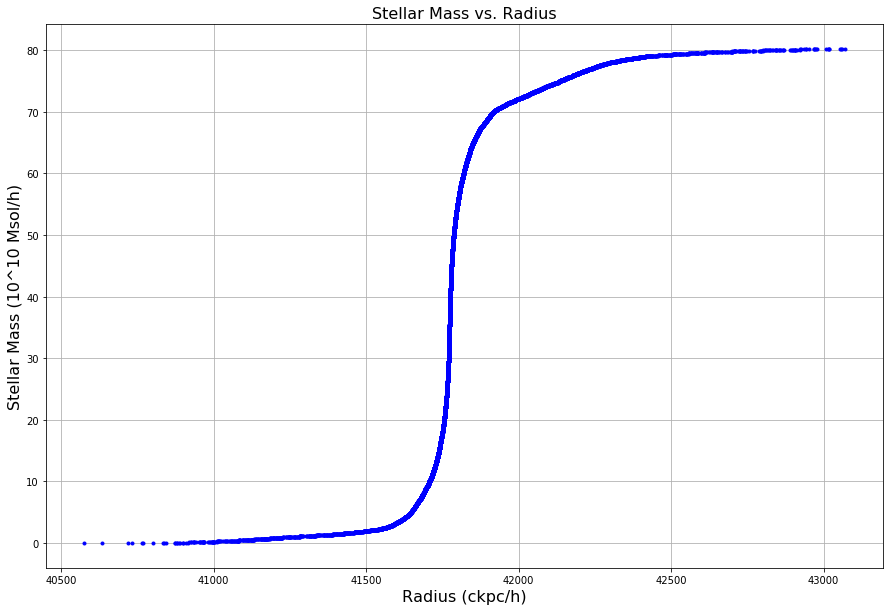

In [26]:
# Should be centered on 0 -- need to figure out why this is doing this
plt.figure(figsize=(15,10))
plt.plot(radius, sum_stellar_mass, 'b.')
plt.title('Stellar Mass vs. Radius',fontsize=16)
plt.xlabel('Radius (ckpc/h)',fontsize=16)
plt.ylabel('Stellar Mass (10^10 Msol/h)',fontsize=16)
plt.grid()

plt.savefig('stellarmass_vs_radius.png')

I attempted to work with the simulation.hdf5 file to see if there was a different way of obtaining the stellar particles for a given central galaxy. The purpose of the simulation.hdf5 file is to encapsulate all data of an entire simulation into a single file.

There are two requirements to use a simulation.hdf5 file:

* Actual data files must be organized exactly as suggested and described in the example scripts tutorial (i.e., an "output" directory containing a "snapdir_099" subdirectory and a "group_099" subdirectory, along with a "postprocessing" directory containing, among others, an "offsets" subdirectory).
* HDF5 virtual datasets are a new feature, only supported by HDF5 version 1.10.x and later. This is not presently the default version installed on most clusters, which still use 1.8.x. You may have to install a newer version yourself, or request that your system administrator do so. Note! Files created with advanced features of the new HDF5 library series are not backwards compatible. The old 1.8.x series of HDF5 reaches end of life in 2019, so it is a good idea regardless to migrate. In Python, you will also need a fairly new version of h5py (e.g. 2.9.x).

I tried downloading the entire snapdir_099 since that is a requirement to use the simulation.hdf5 file (I don't recommend doing unless you have ample space on your computer) and running the example scripts found here: http://www.tng-project.org/data/docs/specifications/#sec3b

Everything had empty arrays so I am not sure what is going on there because I made sure it was in the correct folder. This is as far as I got up to.

# Fitting Functions from Pillepich et al. 2018

This function takes in a relation number as an integer and returns y (the stellar mass). The function also plots the corresponding fitting function in log scale with a label. Possible number inputs are 1-9. Refer to Table 4 in Pillepich et al. 2018 to determine the number for each fitting function.

In [27]:
def illustris_relation(relation):
    Msol = 1
    M_500c = np.linspace(13,15)
    m = M_500c/Msol
    m0 = 14
    
    if relation == 1:
        a = 0.49
        b = 11.77
        sig = 0.12
        y = a*(m-m0)+b
        plot_label = "Central < 30 kpc"
        ylabel = r"Stellar Mass ($M_{stars, cen}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 2:
        a = 0.59
        b = 12
        sig = 0.13
        y = a*(m-m0)+b
        plot_label = "Central < 100 kpc"
        ylabel = r"Stellar Mass ($M_{stars, cen}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 3:
        a = 0.74
        b = 12.02
        sig = 0.12
        y = a*(m-m0)+b
        plot_label = "Central < 2 x r_(stars, 1/2)"
        ylabel = r"Stellar Mass ($M_{stars, cen}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 4:
        a = 1.01
        b = 12.01
        sig = 0.13
        y = a*(m-m0)+b
        plot_label = "ICL > 30 kpc"
        ylabel = r"Stellar Mass ($M_{stars, ICL}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 5:
        a = 1.25
        b = 11.74
        sig = 0.14
        y = a*(m-m0)+b
        plot_label = "ICL > 100 kpc"
        ylabel = r"Stellar Mass ($M_{stars, ICL}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 6:
        a = 0.77
        b = 11.72
        sig = 0.11
        y = a*(m-m0)+b
        plot_label = "ICL > 2 x r_(stars, 1/2)"
        ylabel = r"Stellar Mass ($M_{stars, ICL}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 7:
        a = 1.14
        b = 11.93
        sig = 0.22
        y = a*(m-m0)+b
        plot_label = "Satellites > 1e8 Msun"
        ylabel = r"Stellar Mass ($M_{stars, sats}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 8:
        a = 0.75
        b = 12.19
        sig = 0.11
        y = a*(m-m0)+b
        plot_label =  "Total: central+ICL"
        ylabel = r"Stellar Mass ($M_{stars, tot}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)
        
    if relation == 9:
        a = 0.84
        b = 12.36
        sig = 0.07
        y = a*(m-m0)+b
        plot_label = "Total: central+ICL+satellites"
        ylabel = r"Stellar Mass ($M_{stars, tot}$/$M_{\odot}$)"
        plt.fill_between(m,y+sig,y-sig,alpha=0.5)

        
    plt.plot(M_500c,y,label = plot_label)
    plt.legend()
    plt.xlabel(r"Total Halo Mass ($M_{500c}$/$M_{\odot}$)")
    plt.ylabel(ylabel)
             
    return y

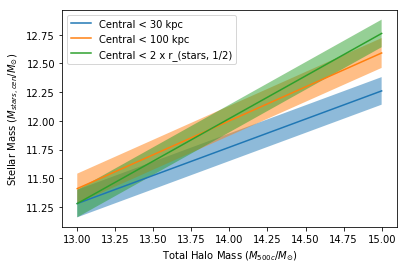

In [28]:
Mstarcentral_Mhalo_30kpc = illustris_relation(1)
Mstarcentral_Mhalo_100kpc = illustris_relation(2)
Mstarcentral_Mhalo_hmr = illustris_relation(3)

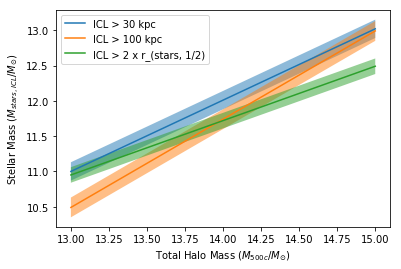

In [29]:
MstarICL_Mhalo_30kpc = illustris_relation(4)
MstarICL_Mhalo_100kpc = illustris_relation(5)
MstarICL_Mhalo_hmr = illustris_relation(6)

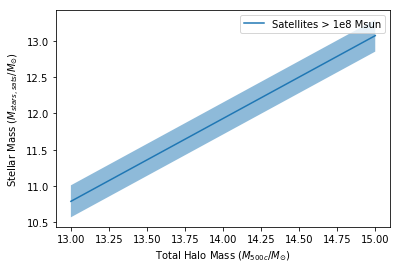

In [30]:
Mstarsat_Mhalo_1e8Msol = illustris_relation(7)

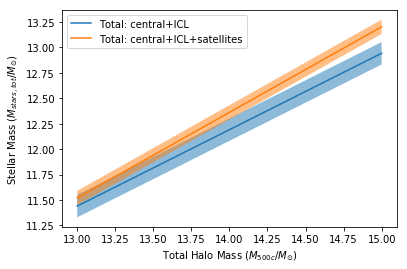

In [31]:
Mstardiff_Mhalo_cenICL = illustris_relation(8)
Mstartot_Mhalo_cenICLsats = illustris_relation(9)

array([11.52      , 11.55428571, 11.58857143, 11.62285714, 11.65714286,
       11.69142857, 11.72571429, 11.76      , 11.79428571, 11.82857143,
       11.86285714, 11.89714286, 11.93142857, 11.96571429, 12.        ,
       12.03428571, 12.06857143, 12.10285714, 12.13714286, 12.17142857,
       12.20571429, 12.24      , 12.27428571, 12.30857143, 12.34285714,
       12.37714286, 12.41142857, 12.44571429, 12.48      , 12.51428571,
       12.54857143, 12.58285714, 12.61714286, 12.65142857, 12.68571429,
       12.72      , 12.75428571, 12.78857143, 12.82285714, 12.85714286,
       12.89142857, 12.92571429, 12.96      , 12.99428571, 13.02857143,
       13.06285714, 13.09714286, 13.13142857, 13.16571429, 13.2       ])

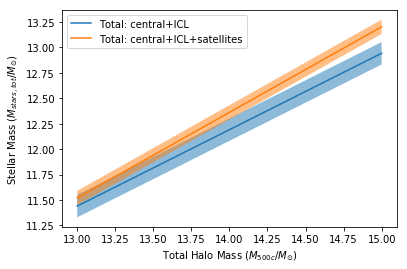

In [32]:
illustris_relation(8)
illustris_relation(9)

In [33]:
def get_R200c(M_halo, halo=True):
    if halo:
        a, b = 0.33, 2.99
    else:
        a, b = 0.70, 2.88
       
    m = M_halo - 14
    R_200c = a*m+b
    return R_200c

def get_Mstars_200c(M_halo, halo=True):
    if halo:
        a, b = 0.74, 12.04
    else:
        a, b = 1.56, 11.80
    m = M_halo - 14
    Mstars_200c = a*m+b
    return Mstars_200c

def get_sigmoidal_slope(M_halo, halo=True):
    if halo:
        a, b = -0.25, 2.14
    else:
        a, b = -0.52, 2.22
    m = M_halo - 14
    sigmoidal_slope = a*m+b
    return sigmoidal_slope

def get_x05(M_halo, halo=True):
    if halo:
        a, b = 0.19, -1.42
    else:
        a, b = 0.41, -1.48
    m = M_halo - 14
    x05 = a*m+b
    return x05

def enclosed_mstar(M_halo, halo=True):
    logR200c = get_R200c(M_halo, halo=halo)
    logMstar_norm = get_Mstars_200c(M_halo)
    slope = get_sigmoidal_slope(M_halo)
    x05 = get_x05(M_halo)
    
    lograd = np.linspace(0, 4)
    print(M_halo, logMstar_norm, logR200c)
    xx = lograd - logR200c
    
    Mstar_enclosed  = 10**logMstar_norm / (1+np.exp(-slope*(xx-x05)))
    Mstar_enclosed_frac = 10**(np.log10(Mstar_enclosed) - logMstar_norm)

    return xx, Mstar_enclosed_frac

13 11.299999999999999 2.66
13 11.299999999999999 2.66
14 12.04 2.99
14 12.04 2.99
15 12.78 3.3200000000000003
15 12.78 3.3200000000000003


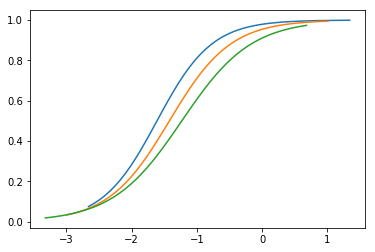

In [34]:
fig, ax = plt.subplots()
for mhalo in (13, 14, 15):
    rad, mstar = enclosed_mstar(mhalo)
    ax.plot(rad, mstar)
    rad, mstar = enclosed_mstar(mhalo, halo=True)